In [2]:
from eodag import EODataAccessGateway, setup_logging
import pprint
import shutil
import os
import numpy as np
from osgeo import gdal, gdal_array, ogr, osr
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import folium
from rasterio.transform import from_origin

change map based on thresholds for positive and negative changes. It considers values above the positive threshold as positive change (e.g., vegetation growth), values below the negative threshold as negative change (e.g., vegetation loss), and values within the thresholds as no significant change. 

In [2]:

# Define a function to download images from the provided date range
def download_images(start_date, end_date):
    setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

    dag = EODataAccessGateway()
    geometry = "POLYGON ((8.863744 36.913785, 8.864516 36.911246, 8.868205 36.912412, 8.86769 36.914951, 8.863744 36.913785))"
    search_results, total_count = dag.search(
        productType="S2_MSI_L1C",
        geom=geometry,
        start=start_date,
        end=end_date,
        cloudCover=4,
    )

    products_to_download = search_results[:2]  # Download 2 images, change as needed
    paths = dag.download_all(products_to_download)
    for file_path in paths:
        destination_path = os.path.join(
            "sentinel2", os.path.basename(file_path)
        )
        shutil.move(file_path, destination_path)

# Download images for the specified date ranges
date_ranges = [
    ("2022-01-20", "2022-02-23"),
    ("2023-11-13", "2023-11-15")
]

for start_date, end_date in date_ranges:
    download_images(start_date, end_date)


Downloaded products:   0%|          | 0/1 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

Downloaded products:   0%|          | 0/1 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

Error: Destination path 'sentinel2/S2B_MSIL1C_20231114T101159_N0509_R022_T32SMF_20231114T121436/S2B_MSIL1C_20231114T101159_N0509_R022_T32SMF_20231114T121436' already exists

In [3]:
import rasterio
import numpy as np

product_paths = [
    ('sentinel2/S2A_MSIL1C_20220128T101301_N0400_R022_T32SMF_20220128T121600/GRANULE/L1C_T32SMF_A034482_20220128T101258/IMG_DATA/T32SMF_20220128T101301_B08.jp2',
     'sentinel2/S2A_MSIL1C_20220128T101301_N0400_R022_T32SMF_20220128T121600/GRANULE/L1C_T32SMF_A034482_20220128T101258/IMG_DATA/T32SMF_20220128T101301_B04.jp2'),
    ('sentinel2/S2B_MSIL1C_20231114T101159_N0509_R022_T32SMF_20231114T121436/GRANULE/L1C_T32SMF_A034940_20231114T101954/IMG_DATA/T32SMF_20231114T101159_B08.jp2',
     'sentinel2/S2B_MSIL1C_20231114T101159_N0509_R022_T32SMF_20231114T121436/GRANULE/L1C_T32SMF_A034940_20231114T101954/IMG_DATA/T32SMF_20231114T101159_B04.jp2')
]

ndvi1_list = []
ndvi2_list = []

for product_IR, product_red in product_paths:
    with rasterio.open(product_IR) as src:
        b8 = src.read(1) 

    with rasterio.open(product_red) as src:
        b4 = src.read(1) 

    ndvi = (b8 - b4) / (b8 + b4 + 1e-8)
    
    if len(ndvi1_list) == 0:
        ndvi1_list.append(ndvi)
    else:
        ndvi2_list.append(ndvi)

# Selecting NDVI1 and NDVI2 separately
ndvi1 = ndvi1_list[0]
ndvi2 = ndvi2_list[0]


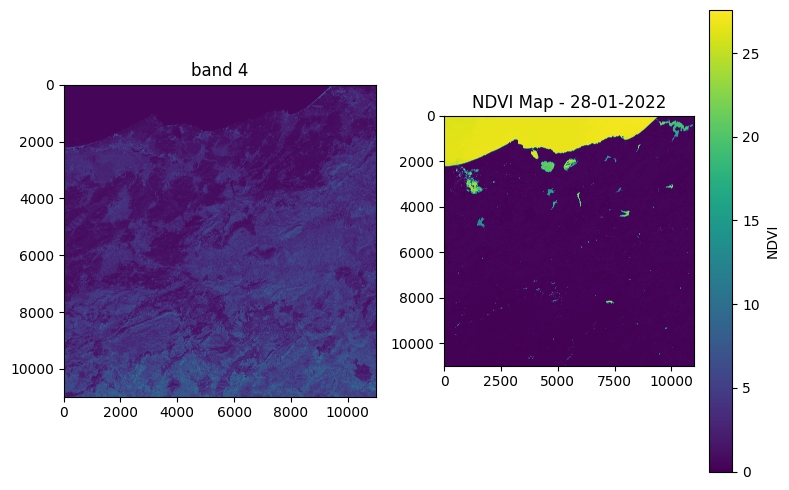

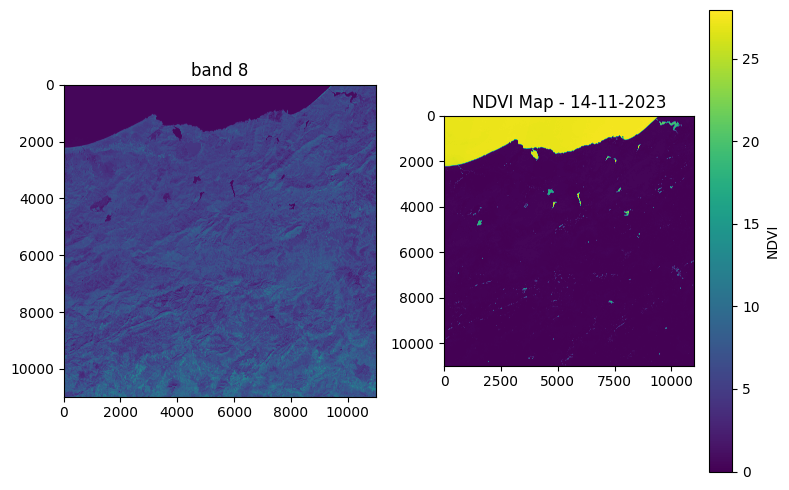

In [4]:

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.imshow(b4)
plt.title('band 4')

# Plotting ndvi2
plt.subplot(1, 2, 2)
plt.imshow(ndvi1)
plt.title('NDVI Map - 28-01-2022')
plt.colorbar(label='NDVI')

plt.tight_layout()
plt.show()


# Plotting ndvi1
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(b8)
plt.title('band 8')

# Plotting ndvi2
plt.subplot(1, 2, 2)
plt.imshow(ndvi2)
plt.colorbar(label='NDVI')
plt.title('NDVI Map - 14-11-2023')

plt.tight_layout()
plt.show()



In [6]:
# Define the change vector (NDVI_t2 - NDVI_t1)
change_vector = 1 - ndvi2

# Define thresholds for significant positive and negative changes
positive_threshold = 0.1  # For vegetation gain
negative_threshold = -0.1  # For vegetation loss

# Create a change map based on thresholds
change_map = np.zeros_like(change_vector, dtype=np.uint8)  # Initialize change map

# Classify changes: 1 for vegetation gain, 2 for vegetation loss, 3 for no significant change
change_map[change_vector > positive_threshold] = 1
change_map[change_vector < negative_threshold] = 2
change_map[
    (change_vector >= negative_threshold) & (change_vector <= positive_threshold)
] = 3

In [ ]:
# Define the file path for saving the GeoTIFF
output_path = "change_map.tif"

# Define the metadata for the GeoTIFF
meta = {
    'driver': 'GTiff',
    'width': change_map.shape[1],
    'height': change_map.shape[0],
    'count': 1,
    'dtype': 'uint8',
    'crs': 'EPSG:4326',  # Specify the CRS if known
    'transform': from_origin(0, 0, 1, 1)  # Adjust the transformation values as needed
}

# Write the change map to a GeoTIFF file
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(change_map, 1)

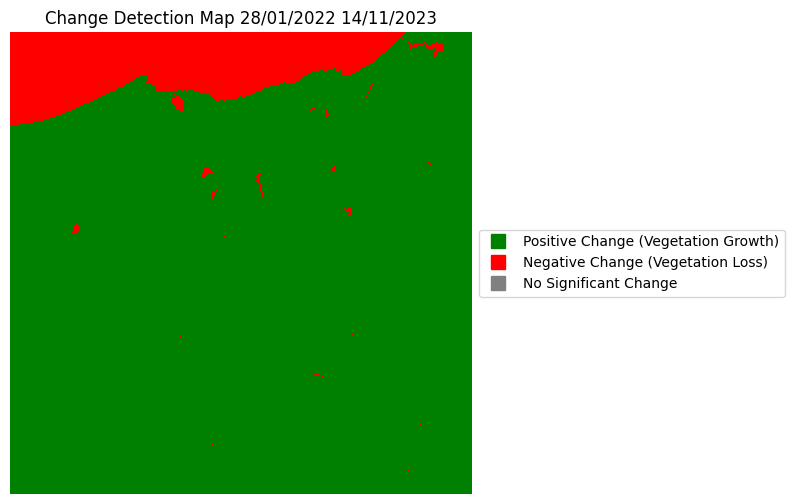

In [7]:


# Define color map for different change classes
colors = ['green', 'red', 'gray']  # Assign colors f
cmap = ListedColormap(colors)

# Plot the change map with colors and legend outside the plot
plt.figure(figsize=(8, 6))
plt.imshow(change_map, cmap=cmap, vmin=1, vmax=3)  # Set vmin and vmax to match class range
plt.title('Change Detection Map 28/01/2022 14/11/2023')
plt.axis('off')

# Create a legend outside the plot
legend_labels = ['Positive Change (Vegetation Growth)', 'Negative Change (Vegetation Loss)', 'No Significant Change']
patches = [plt.plot([], [], marker='s', color=color, markersize=10, linestyle='')[0] for color in colors]
plt.legend(patches, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

